# Sedov Blast Wave with Cosmic Rays

## Imports

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

import jax.numpy as jnp
import matplotlib.pyplot as plt

# units
from jf1uids import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# jf1uids data structures
from jf1uids import SimulationConfig
from jf1uids import SimulationParams

# jf1uids constants
from jf1uids.option_classes.simulation_config import CARTESIAN, SPHERICAL, HLL, MINMOD


# jf1uids functions
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import finalize_config

from jf1uids import time_integration

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters - except for the inclusion of Cosmic Rays.

In [26]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayConfig


config = SimulationConfig(

    
    geometry = SPHERICAL,
    first_order_fallback = True,
    progress_bar = False,
    runtime_debugging = False,


    # ====== RESOLUTION =======
    num_cells = 5001,
    # =========================


    # =========================
    # NOTE: THE INJECTION RADIUS CURRENTLY
    # IS AT THE 10th CELL. IF YOU CHOOSE
    # AN INJECTION RADIUS TOO BIG
    # THIS WILL LEAD TO A DIFFERENT SOLUTION
    # STRUCTURE AKIN TO A SHOCK TUBE.
    # =========================


    # ======= COSMIC RAY SWITCH =======
    # ONLY ADVECTIVE COSMIC RAYS,
    # FOLLOWING doi.org/10.1088/1742-6596/719/1/012021
    # BUT JUST USING A NORMAL HLL SOLVER
    # WHICH IS MORE DIFFUSIVE BUT DOES NOT REQUIRE
    # A FIX AGAINST OSCILLATIONS AS NECESSARY FOR
    # A ROE SOLVER.
    cosmic_ray_config = CosmicRayConfig(
                            cosmic_rays = True,
                            diffusive_shock_acceleration = True,
                        ),
    # =================================


    # ==== snapshotting ====
    return_snapshots = True,
    num_snapshots = 20,
    # ======================

)

Next we setup the simulation parameters, things we might vary

In [27]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayParams


params = SimulationParams(
    t_end = 0.1,
    cosmic_ray_params = CosmicRayParams(
        diffusive_shock_acceleration_start_time = 0.0001,
        diffusive_shock_acceleration_efficiency = 0.5
    ),
    dt_max = 0.00001
)

With this we generate some helper data, like the cell centers etc.

In [28]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

Next we setup Sedov Taylor Explosion

In [29]:
# total explosion energy
E_explosion = 1.0

# partition of energy: fraction into cosmic rays
if config.cosmic_ray_config.diffusive_shock_acceleration:
    f_cr = 0.0
else:
    f_cr = 0.0  # 10% of energy into cosmic rays

E_gas = (1 - f_cr) * E_explosion
E_cr  = f_cr * E_explosion

# Ambient (background) physical conditions (adjust as needed)
rho_ambient_phys  = 1.0         # typical ISM density
p_ambient_phys    = 1e-4          # low gas pressure
p_cr_ambient_phys = 0          # low cosmic ray pressure

# Density in code units
rho_ambient = rho_ambient_phys

# Pressures in code units
p_ambient   = p_ambient_phys
p_cr_ambient = p_cr_ambient_phys

# --- Set Up the Explosion Injection Region ---

# currently, we take 10 injection cells
r_explosion_phys = helper_data.outer_cell_boundaries[9]
r_explosion = r_explosion_phys

# Compute the injection volume (spherical volume in code units)
injection_volume = (4/3) * jnp.pi * r_explosion_phys**3

# Adiabatic indices:
gamma_gas = params.gamma   # for the thermal gas
gamma_cr  = 4/3   # for cosmic rays

# The energy contained in a uniform pressure region is related by:
#   E = p * V / (gamma - 1)
# Hence, the effective explosion pressure in the injection region (in code units)
p_explosion_gas_phys = E_gas * (gamma_gas - 1) / injection_volume
p_explosion_cr_phys  = E_cr  * (gamma_cr  - 1) / injection_volume

# Convert to code units
p_explosion_gas = p_explosion_gas_phys
p_explosion_cr  = p_explosion_cr_phys

# --- Define the Radial Profiles ---
# Get the radial coordinate array (assumed already available)
r = helper_data.geometric_centers  # e.g. radial centers of the grid cells

# Density: assume uniform ambient density everywhere
rho = rho_ambient * jnp.ones_like(r)

# Radial velocity: initially at rest
u_r = jnp.zeros_like(r)

# Gas pressure: high within the explosion region, ambient elsewhere
p_gas = jnp.where(r < r_explosion, p_explosion_gas, p_ambient)

# Cosmic ray pressure: similarly high inside the explosion region, ambient outside
p_cr = jnp.where(r < r_explosion, p_explosion_cr, p_cr_ambient)

# --- Build the Initial State ---
initial_state = construct_primitive_state(
    registered_variables=registered_variables,
    config=config,
    density=rho,
    velocity_x=u_r,
    gas_pressure=p_gas,
    cosmic_ray_pressure=p_cr
)

config = finalize_config(config, initial_state.shape)

For spherical geometry, only HLL is currently supported.
Automatically setting reflective left and open right boundary for spherical geometry.


## Running the simulation

In [30]:
result = time_integration(initial_state, config, params, helper_data, registered_variables)

In [31]:
final_state = result.states[-1]

rho_final = final_state[registered_variables.density_index]
u_final = final_state[registered_variables.velocity_index]
p_final = final_state[registered_variables.pressure_index]
n_cr_final = final_state[registered_variables.cosmic_ray_n_index]
p_cr_final = n_cr_final ** gamma_cr
if config.cosmic_ray_config.cosmic_rays:
    p_gas_final = p_final - p_cr_final
else:
    p_gas_final = p_final

Convert back to physical units

Lets also get the shock radius

2360 2370
2368


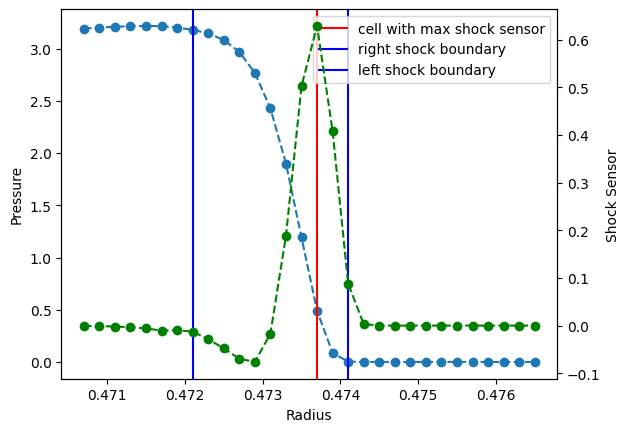

In [32]:
from jf1uids.shock_finder.shock_finder import find_shock_zone, shock_sensor


sensors = shock_sensor(final_state[registered_variables.pressure_index])

shock_index = jnp.argmax(shock_sensor(final_state[registered_variables.pressure_index]))

shock_index_right, shock_index_left = find_shock_zone(final_state[registered_variables.pressure_index])

print(shock_index_right, shock_index_left)


to_next_sensor_differences = jnp.zeros_like(sensors)
to_next_sensor_differences = to_next_sensor_differences.at[:-1].set(sensors[1:] - sensors[:-1])

to_last_sensor_differences = jnp.zeros_like(sensors)
to_last_sensor_differences = to_last_sensor_differences.at[1:].set(sensors[:-1] - sensors[1:])

ax1 = plt.gca()
ax1.plot(helper_data.geometric_centers[shock_index - 15:shock_index + 15], final_state[registered_variables.pressure_index, shock_index - 15:shock_index + 15], "o--")
# mark vertical line at the shock
ax2 = plt.gca().twinx()
ax2.plot(helper_data.geometric_centers[shock_index - 15:shock_index + 15], shock_sensor(final_state[registered_variables.pressure_index])[shock_index - 15:shock_index + 15], "o--", color='green')
ax2.set_ylabel('Shock Sensor')

# ax2.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], to_next_sensor_differences[shock_index - 10:shock_index + 10], "o--", color='red', label='to next')
# ax2.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], to_last_sensor_differences[shock_index - 10:shock_index + 10], "o--", color='blue', label='to last')

# ax2.legend(loc = 'upper left')

ax1.axvline(helper_data.geometric_centers[shock_index], color='red', label='cell with max shock sensor')
ax1.axvline(helper_data.geometric_centers[shock_index_right], color='blue', label='right shock boundary')
ax1.axvline(helper_data.geometric_centers[shock_index_left], color='blue', label='left shock boundary')

print(shock_index)

ax1.set_ylabel('Pressure')
ax1.set_xlabel('Radius')
ax1.legend(loc = 'upper right')

In [33]:
print(registered_variables.cosmic_ray_n_active)

True


## Visualization

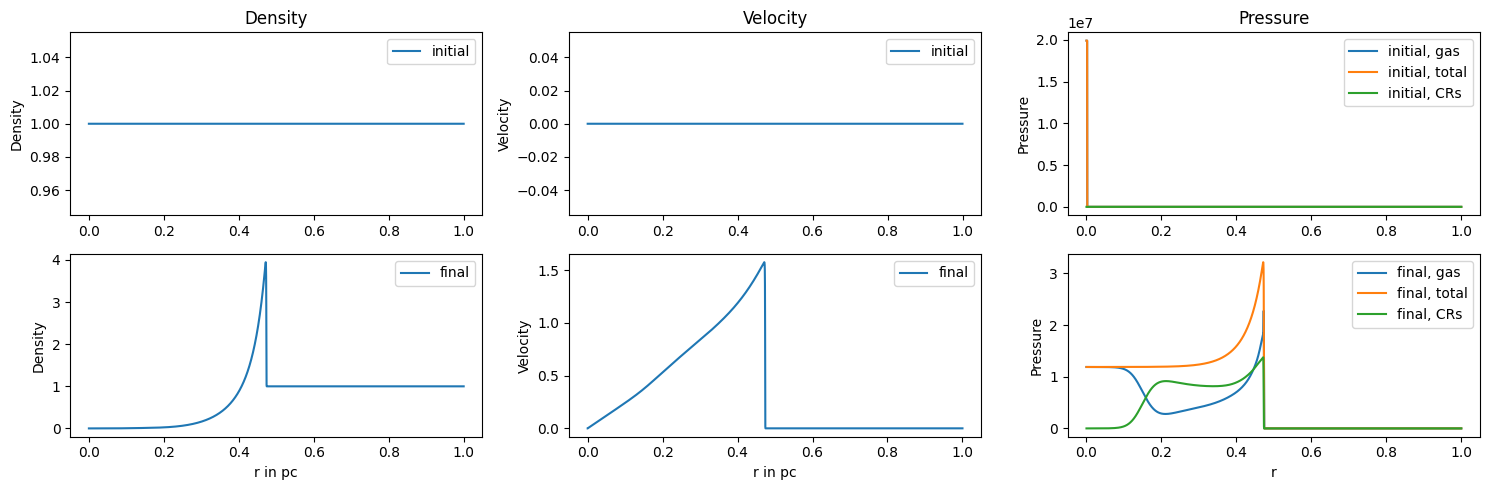

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

a = 0
b = -1

axs[0, 0].plot(r[a:b], rho[a:b], label='initial')
axs[0, 0].set_ylabel('Density')
axs[1, 0].plot(r[a:b], rho_final[a:b], label='final')
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_xlabel('r in pc')
axs[0, 0].set_title('Density')
axs[0, 0].legend()
axs[1, 0].legend()

axs[0, 1].plot(r[a:b], u_r[a:b], label='initial')
axs[0, 1].set_ylabel('Velocity')
axs[1, 1].plot(r, u_final, label='final')
axs[1, 1].set_ylabel('Velocity')
axs[1, 1].set_xlabel('r in pc')
axs[0, 1].set_title('Velocity')
axs[0, 1].legend()
axs[1, 1].legend()

axs[0, 2].plot(r[a:b], p_gas[a:b], label='initial, gas')
axs[1, 2].plot(r[a:b], p_gas_final[a:b], label='final, gas')

if config.cosmic_ray_config.cosmic_rays:
    axs[0, 2].plot(r[a:b], p_gas[a:b] + p_cr[a:b], label='initial, total')
    axs[1, 2].plot(r[a:b], p_final[a:b], label='final, total')
    axs[0, 2].plot(r[a:b], p_cr[a:b], label='initial, CRs')
    axs[1, 2].plot(r[a:b], p_cr_final[a:b], label='final, CRs')

axs[0, 2].set_ylabel('Pressure')
axs[1, 2].set_ylabel('Pressure')
axs[1, 2].set_xlabel('r')

axs[0, 2].set_title('Pressure')
axs[0, 2].legend()
axs[1, 2].legend()

plt.tight_layout()

In [ ]:
helper_data.cell_volumes

In [35]:
# from exactpack.solvers.sedov import Sedov

# from matplotlib import pyplot as plt

# import numpy as np

# # here are the defaults
# geometry = 3
# gamma = 7/5
# rho0 = 1.0
# omega = 0.0
# eblast = 1.0

# solver = Sedov(geometry=3.0, gamma=params.gamma, rho0=rho0, omega=omega, eblast=eblast)

# rep = np.linspace(0, 1, 1000)

# soln = solver(rep, 0.1)

# plt.plot(rep, soln['pressure'])

## Animation

In [36]:
# from matplotlib.animation import FuncAnimation

# fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# def plot_state(i):
#     axs[0, 0].cla()
#     axs[1, 0].cla()
#     axs[0, 1].cla()
#     axs[1, 1].cla()
#     axs[0, 2].cla()
#     axs[1, 2].cla()

#     final_state = result.states[i]

#     rho_init = initial_state[registered_variables.density_index]
#     u_r = initial_state[registered_variables.velocity_index]

#     rho_final = final_state[registered_variables.density_index]
#     u_final = final_state[registered_variables.velocity_index]
#     p_final = final_state[registered_variables.pressure_index]
#     n_cr_final = final_state[registered_variables.cosmic_ray_n_index]
#     p_cr_final = n_cr_final ** gamma_cr
#     if config.cosmic_ray_config.cosmic_rays:
#         p_gas_final = p_final - p_cr_final
#     else:
#         p_gas_final = p_final

#     r = (helper_data.geometric_centers * code_units.code_length).to(u.pc)
#     rho = (rho_init * code_units.code_density).to(m_p / u.cm**3)
#     rho_final = (rho_final * code_units.code_density).to(m_p / u.cm**3)
#     u_r = (u_r * code_units.code_velocity).to(u.km / u.s)
#     u_final = (u_final * code_units.code_velocity).to(u.km / u.s)
#     p = (p_gas_final * code_units.code_pressure / c.k_B).to(u.K / u.cm**3)
#     p_cr = (p_cr_final * code_units.code_pressure / c.k_B).to(u.K / u.cm**3)

#     axs[0, 0].plot(r, rho, label='initial')
#     axs[0, 0].set_ylabel('Density in $m_p / cm^3$')
#     axs[1, 0].plot(r, rho_final, label='final')
#     axs[1, 0].set_ylabel('Density in $m_p / cm^3$')
#     axs[1, 0].set_xlabel('r in pc')
#     axs[0, 0].set_title('Density')
#     axs[0, 0].legend()
#     axs[1, 0].legend()

#     axs[0, 1].plot(r, u_r, label='initial')
#     axs[0, 1].set_ylabel('Velocity in km/s')
#     axs[1, 1].plot(r, u_final, label='final')
#     axs[1, 1].set_ylabel('Velocity in km/s')
#     axs[1, 1].set_xlabel('r in pc')
#     axs[0, 1].set_title('Velocity')
#     axs[0, 1].legend()
#     axs[1, 1].legend()

#     axs[0, 2].plot(r, p_gas, label='initial, gas')
#     axs[1, 2].plot(r, p_gas_final, label='final, gas')

#     if config.cosmic_ray_config.cosmic_rays:
#         axs[0, 2].plot(r, p_gas + p_cr, label='initial, total')
#         axs[1, 2].plot(r, p_final, label='final, total')
#         axs[0, 2].plot(r, p_cr, label='initial, CRs')
#         axs[1, 2].plot(r, p_cr_final, label='final, CRs')

#     axs[0, 2].set_ylabel('Pressure / $k_B$ in $K / cm^3$')
#     axs[1, 2].set_ylabel('Pressure / $k_B$ in $K / cm^3$')
#     axs[1, 2].set_xlabel('r in pc')

#     axs[0, 2].set_title('Pressure')
#     axs[0, 2].legend()
#     axs[1, 2].legend()

#     # axs[1, 0].set_ylim(0, 4)
#     # axs[1, 1].set_ylim(0, 10000)
#     # axs[1, 2].set_ylim(0, 4e10)

#     plt.tight_layout()

# ani = FuncAnimation(fig, plot_state, frames=len(result.states), interval=200)
# ani.save("sedov.gif")